
 # 🧬 DNA Promoter Sequence Classification
 
 This notebook analyzes DNA sequences and classifies them as promoter or non-promoter regions using machine learning techniques.
 
 ## Project Overview:
 1. **Data Loading** - Download Kaggle dataset
 2. **Feature Engineering** - Extract biological features
 3. **Exploratory Data Analysis** - Visualizations and statistics
 4. **Machine Learning** - Train and compare models


## 1. Data Loading

### Library Imports

In [1]:
# Import all required libraries
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

### Machine Learning Imports

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator

### Data Loading

In [3]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("samira1992/promoter-or-not-bioinformatics-dataset")
print(" Path to dataset files:", path)

# Show available files
print("\n Available files:")
for file in os.listdir(path):
    print(f"   • {file}")


 Path to dataset files: C:\Users\Jannis\.cache\kagglehub\datasets\samira1992\promoter-or-not-bioinformatics-dataset\versions\3

 Available files:
   • bendability.tsv
   • non_promoter.csv
   • promoter.csv


In [4]:
# Load CSV files
df_non = pd.read_csv(os.path.join(path, "non_promoter.csv"), header=None, names=["sequence"])
df_pro = pd.read_csv(os.path.join(path, "promoter.csv"), header=None, names=["sequence"])
df_bend = pd.read_csv(os.path.join(path, "bendability.tsv"), sep="\t", header=None, names=["tri", "score"])

print(f"Non-promoter sequences: {len(df_non)}")
print(f"Promoter sequences: {len(df_pro)}")
print(f"Bendability triplets: {len(df_bend)}")


Non-promoter sequences: 30001
Promoter sequences: 30001
Bendability triplets: 64


### Data Preparation

In [5]:
df_non["label"] = 0  # Non-promoter
df_pro["label"] = 1  # Promoter

# Create bendability dictionary (for DNA flexibility)
bend_dict = {k.upper(): v for k, v in zip(df_bend["tri"], df_bend["score"])}

# Combine DataFrames
df = pd.concat([df_non, df_pro], ignore_index=True)

print(f"Data prepared:")
print(f"Total sequences: {len(df)}")
print(f"Bendability dictionary size: {len(bend_dict)}")

print("="*80)
print(f"Dataset Info:")
print(df.info())
print("="*80)
display(df.head())
print("="*80)
print(f"Label distribution:")
print(df['label'].value_counts())

Data prepared:
Total sequences: 60002
Bendability dictionary size: 64
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60002 entries, 0 to 60001
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  60002 non-null  object
 1   label     60002 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 937.7+ KB
None


,sequence,label
0,non Promoter sequences,0
1,ATCTCTAGCTCCTATACCACCACCACCACCATTACAGCGCCTCCCT...,0
2,ACTTTTTTCATGTTCTCCTTGAGTGAAGGATGAGGAAATTGAAAGC...,0
3,ATCTCCAGAGGGAGTCCAATCCCTGTCCTGTAATAACTGTAGAGCA...,0
4,CCTGGTGACCAAGGTGGTGGCGGTGGACGCAGACTCGGGATACAAC...,0


Label distribution:
label
0    30001
1    30001
Name: count, dtype: int64


## 2. Feature Engineering
 
 We'll extract biologically relevant features from DNA sequences:
 - **GC Content**: Proportion of G and C nucleotides
 - **CpG Ratio**: Observed/Expected CpG dinucleotides
 - **TATA Box**: Presence of TATA box sequence
 - **Bendability**: DNA flexibility based on triplet scores
 - **Nucleotide Frequencies**: Individual A, T, G, C frequencies
 - **Purine/Pyrimidine Ratio**: Biochemical classification


### Feature Functions Definition

In [6]:
def gc_content(seq):
    """Calculate GC content of a sequence"""
    seq = seq.upper()
    gc_count = seq.count('G') + seq.count('C')
    return gc_count / len(seq) if len(seq) > 0 else 0

def cpg_ratio(seq):
    """Calculate CpG Observed/Expected ratio"""
    seq = seq.upper()
    g_count = seq.count('G')
    c_count = seq.count('C')
    cg_count = seq.count('CG')
    
    if len(seq) == 0:
        return 0
    
    expected = (g_count * c_count) / len(seq)
    return cg_count / expected if expected > 0 else 0

def tata_box_presence(seq):
    """Check for TATA box presence"""
    return 1 if "TATA" in seq.upper() else 0

def avg_bendability(seq):
    """Calculate average DNA bendability"""
    seq = seq.upper()
    scores = []
    
    for i in range(len(seq) - 2):
        tri = seq[i:i+3]
        if tri in bend_dict:
            scores.append(bend_dict[tri])
    
    return np.mean(scores) if scores else 0

def nucleotide_frequencies(seq):
    """Calculate nucleotide frequencies (A, T, G, C)"""
    seq = seq.upper()
    length = len(seq)
    if length == 0:
        return 0, 0, 0, 0
    
    return (seq.count('A')/length, seq.count('T')/length, 
            seq.count('G')/length, seq.count('C')/length)

def purine_pyrimidine_ratio(seq):
    """Calculate purine/pyrimidine ratio"""
    seq = seq.upper()
    purines = seq.count('A') + seq.count('G')      # Purines
    pyrimidines = seq.count('C') + seq.count('T')  # Pyrimidines
    return purines / pyrimidines if pyrimidines > 0 else 0

### Feature Creation

In [7]:
df["sequence"] = df["sequence"].astype(str)
df["gc_content"] = df["sequence"].apply(gc_content)
df["cpg_ratio"] = df["sequence"].apply(cpg_ratio)
df["tata_box_presence"] = df["sequence"].apply(tata_box_presence)
df["bendability"] = df["sequence"].apply(avg_bendability)


In [8]:
# Nucleotide frequencies
nucleotide_freq = df["sequence"].apply(nucleotide_frequencies)
df[["freq_A", "freq_T", "freq_G", "freq_C"]] = pd.DataFrame(nucleotide_freq.tolist(), index=df.index)

# Purine/Pyrimidine ratio
df["purine_pyrimidine_ratio"] = df["sequence"].apply(purine_pyrimidine_ratio)

print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1] - 2}")  # -2 for sequence and label


Dataset shape: (60002, 11)
Number of features: 9


In [9]:
# Define feature columns
feature_cols = ['gc_content', 'cpg_ratio', 'tata_box_presence', 
                'bendability', 'freq_A', 'freq_T', 'freq_G', 'freq_C', 
                'purine_pyrimidine_ratio']

# Display feature statistics
print("Feature Statistics:")
display(df[feature_cols + ['label']].describe())

Feature Statistics:


,gc_content,cpg_ratio,tata_box_presence,bendability,freq_A,freq_T,freq_G,freq_C,purine_pyrimidine_ratio,label
count,60002.000000,60002.000000,60002.000000,60002.000000,60002.000000,60002.000000,60002.000000,60002.000000,60002.000000,60002.000000
mean,0.531247,0.552361,0.353305,-0.022135,0.228596,0.240012,0.267134,0.264113,1.020690,0.500000
std,0.143879,0.397034,0.478000,0.015905,0.078659,0.085494,0.086970,0.080812,0.352169,0.500004
min,0.045455,0.000000,0.000000,-0.168526,0.000000,0.009967,0.000000,0.000000,0.000000,0.000000
25%,0.414343,0.211279,0.000000,-0.030542,0.167331,0.172757,0.199203,0.203187,0.832117,0.000000
50%,0.524917,0.476010,0.000000,-0.019610,0.227092,0.235060,0.258964,0.258964,0.980263,0.500000
75%,0.645418,0.870949,1.000000,-0.011704,0.286853,0.306773,0.328904,0.318937,1.165468,1.000000
max,0.906977,3.157343,1.000000,0.097960,0.697211,0.549801,0.677741,0.617530,49.200000,1.000000


## 3. Exploratory Data 
Visualizing data to identify patterns and differences between promoter and non-promoter sequences.

In [10]:
# Dataset overview
print("=== DATASET OVERVIEW ===")
print(f"Total sequences: {len(df):,}")
print(f"Promoters: {sum(df['label']):,} ")
print(f"Non-promoters: {len(df) - sum(df['label']):,}")
print(f"Features: {len(feature_cols)}")

# Check class balance
label_counts = df['label'].value_counts()
balance_ratio = min(label_counts) / max(label_counts)


=== DATASET OVERVIEW ===
Total sequences: 60,002
Promoters: 30,001 
Non-promoters: 30,001
Features: 9


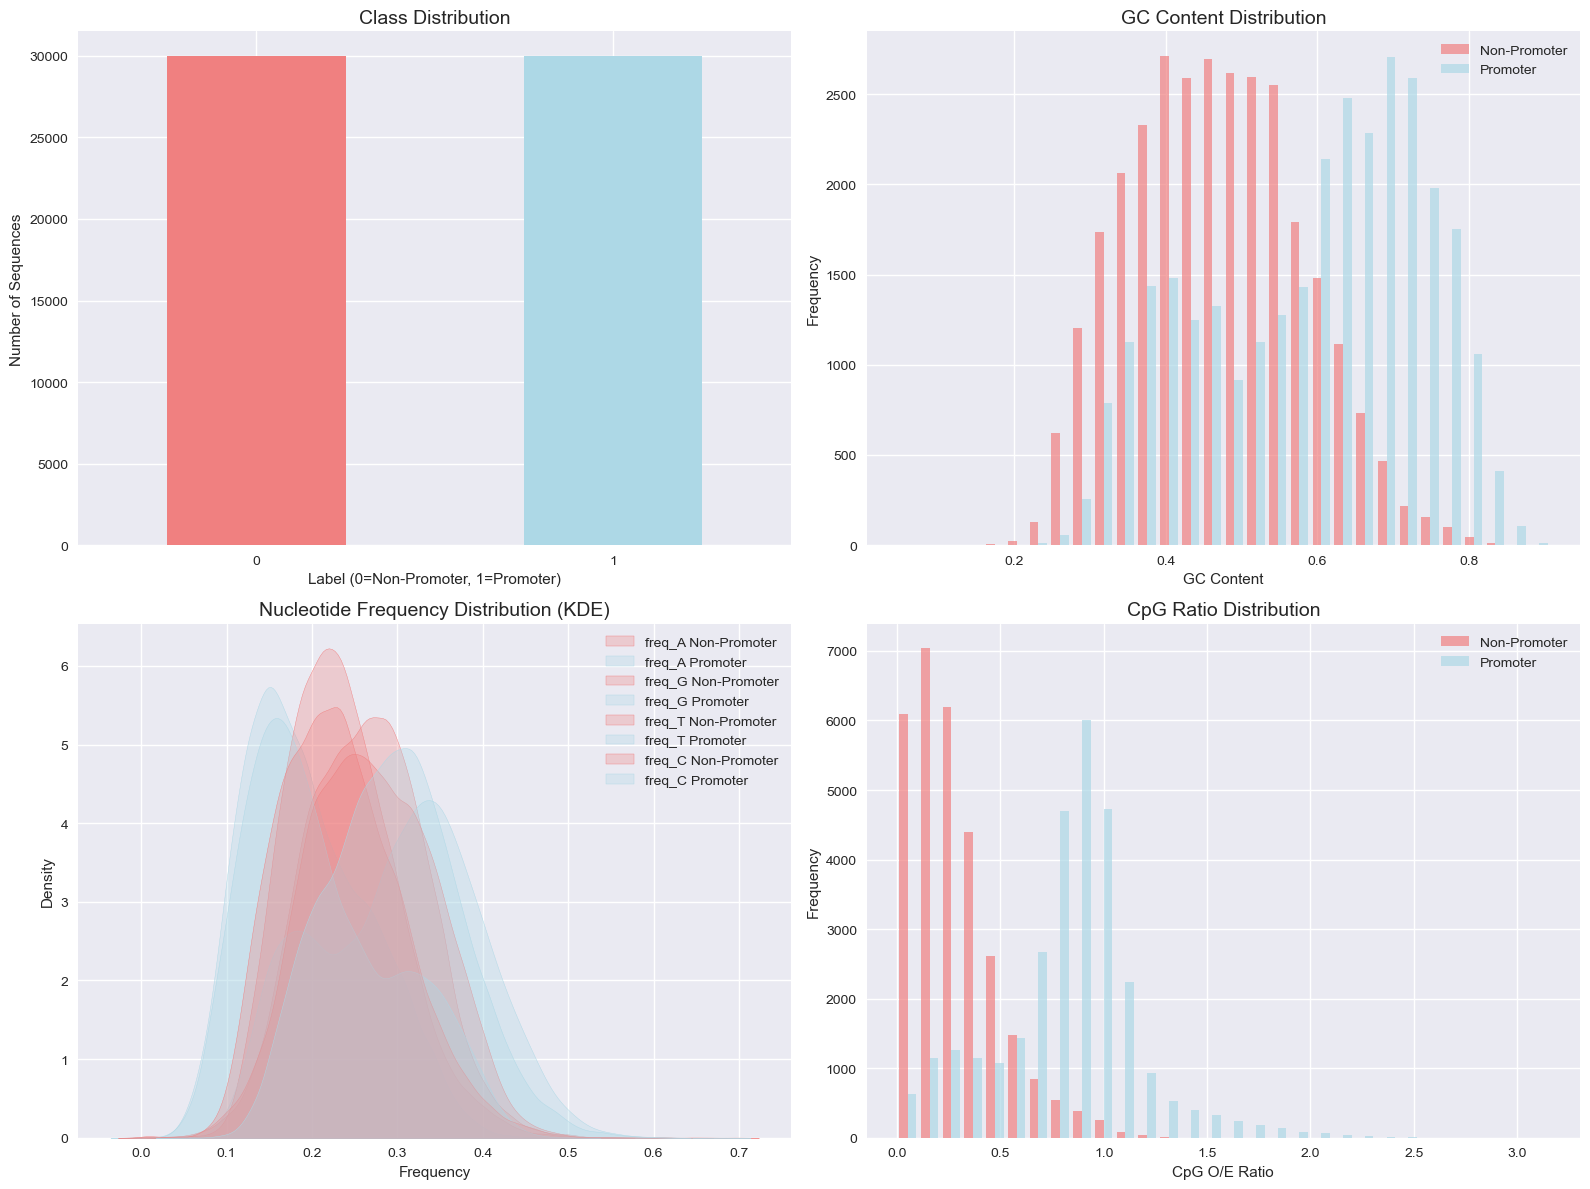

In [11]:
# Main visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Class distribution
df['label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['lightcoral', 'lightblue'])
axes[0,0].set_title('Class Distribution', fontsize=14)
axes[0,0].set_xlabel('Label (0=Non-Promoter, 1=Promoter)')
axes[0,0].set_ylabel('Number of Sequences')
axes[0,0].tick_params(axis='x', rotation=0)

# 2. GC content distribution
axes[0,1].hist([df[df['label']==0]['gc_content'], df[df['label']==1]['gc_content']], 
               bins=30, alpha=0.7, label=['Non-Promoter', 'Promoter'], color=['lightcoral', 'lightblue'])
axes[0,1].set_title('GC Content Distribution', fontsize=14)
axes[0,1].set_xlabel('GC Content')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()


for base in ['freq_A', 'freq_G', 'freq_T', 'freq_C']:
    sns.kdeplot(data=df[df['label'] == 0], x=base, fill=True, alpha=0.3, 
                label=f'{base} Non-Promoter', color='lightcoral', ax=axes[1,0])
    sns.kdeplot(data=df[df['label'] == 1], x=base, fill=True, alpha=0.3, 
                label=f'{base} Promoter', color='lightblue', ax=axes[1,0])

axes[1,0].set_title('Nucleotide Frequency Distribution (KDE)', fontsize=14)
axes[1,0].set_xlabel('Frequency')
axes[1,0].set_ylabel('Density')
axes[1,0].legend()

# 4. CpG ratio
axes[1,1].hist([df[df['label']==0]['cpg_ratio'], df[df['label']==1]['cpg_ratio']], 
               bins=30, alpha=0.7, label=['Non-Promoter', 'Promoter'], color=['lightcoral', 'lightblue'])
axes[1,1].set_title('CpG Ratio Distribution', fontsize=14)
axes[1,1].set_xlabel('CpG O/E Ratio')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

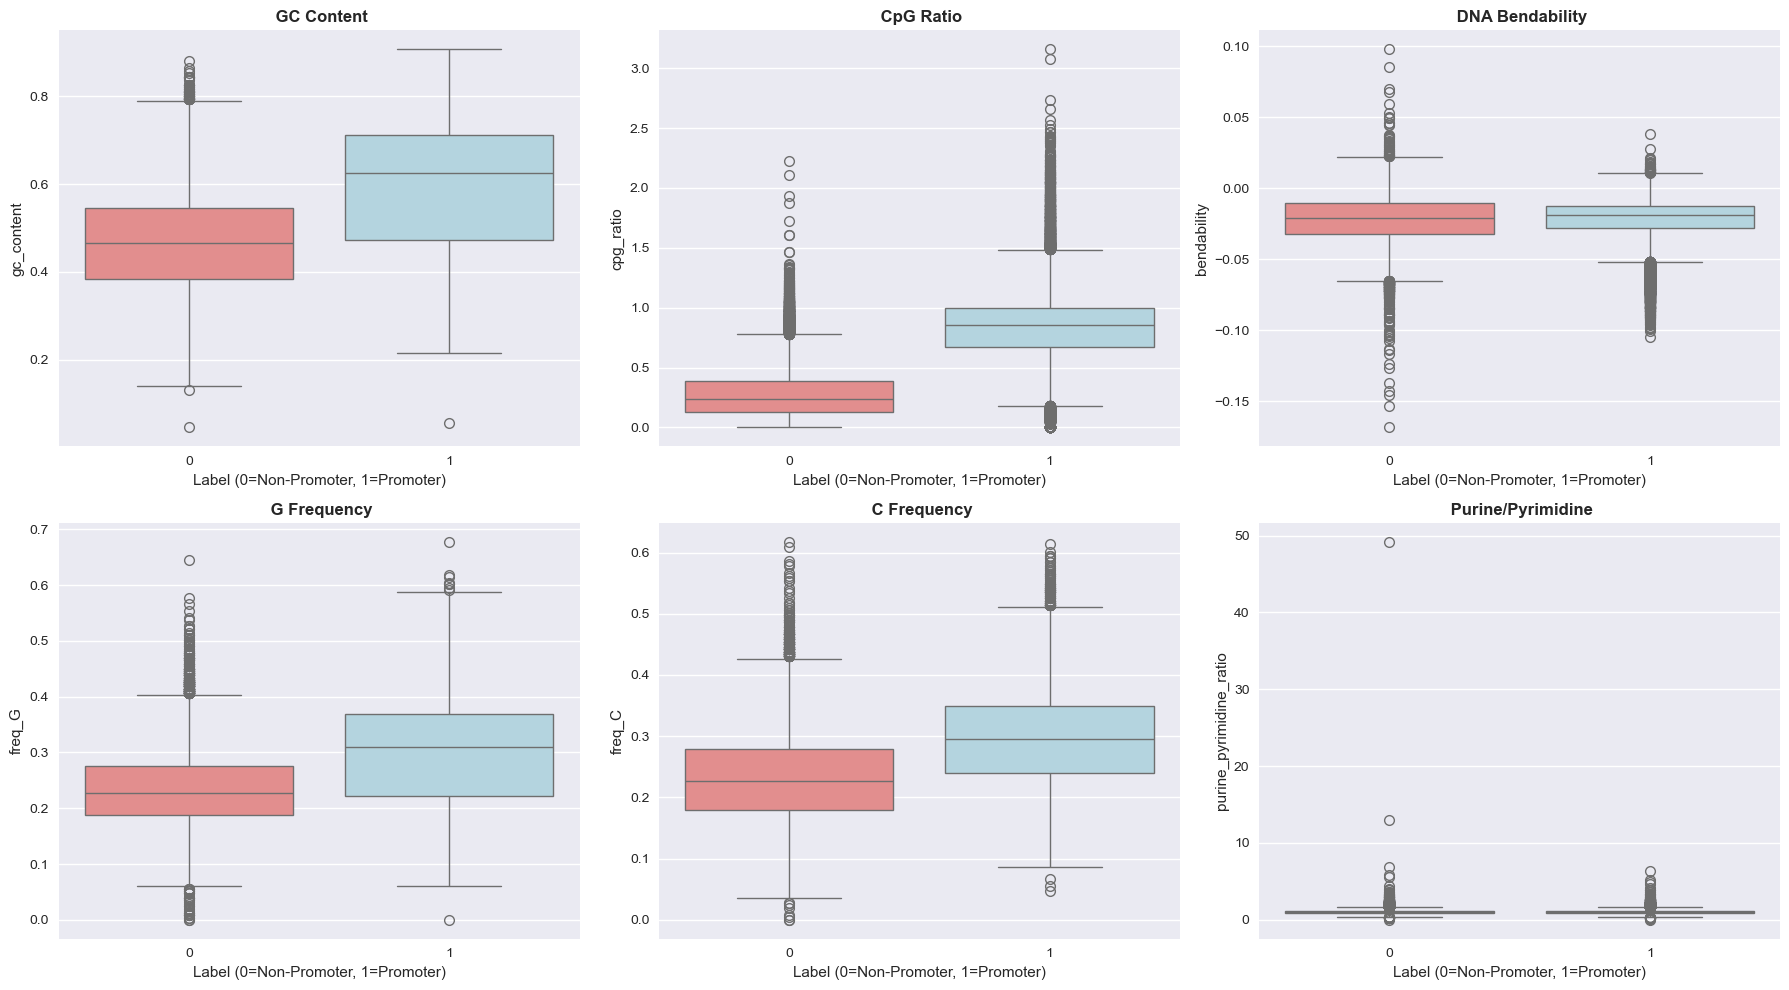

In [12]:
# Boxplots for detailed comparisons
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

features_to_plot = ['gc_content', 'cpg_ratio', 'bendability', 'freq_G', 'freq_C', 'purine_pyrimidine_ratio']
titles = ['GC Content', 'CpG Ratio', 'DNA Bendability', 'G Frequency', 'C Frequency', 'Purine/Pyrimidine']

for i, (feature, title) in enumerate(zip(features_to_plot, titles)):
    row, col = i // 3, i % 3
    sns.boxplot(data=df, x='label', y=feature, ax=axes[row, col], palette=['lightcoral', 'lightblue'])
    axes[row, col].set_title(f' {title}', fontweight='bold')
    axes[row, col].set_xlabel('Label (0=Non-Promoter, 1=Promoter)')

plt.tight_layout()
plt.show()


### Correlation Analysis

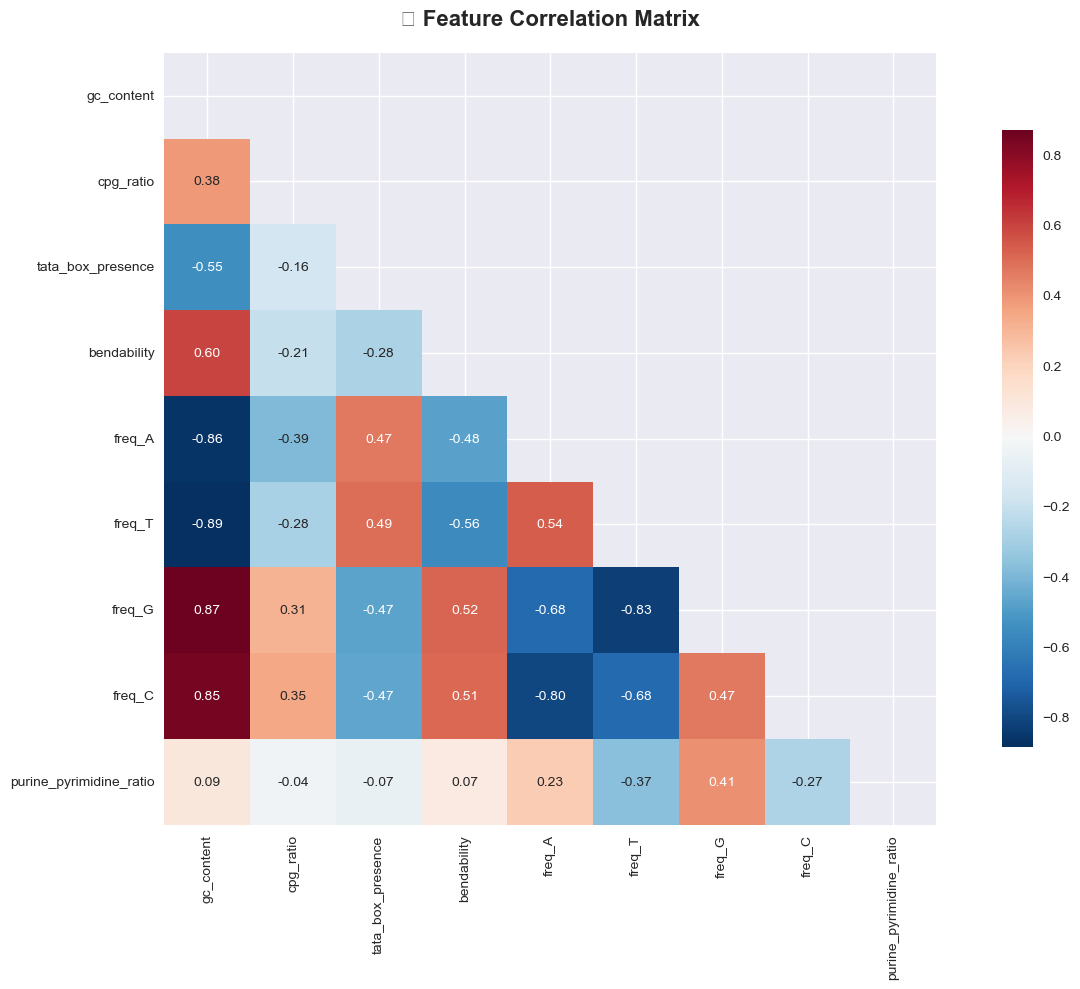

In [13]:
# Correlation matrix
plt.figure(figsize=(14, 10))
corr_matrix = df[feature_cols].corr()
mask = np.triu(np.ones_like(corr_matrix))

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f', 
            square=True,mask=mask,cbar_kws={"shrink": 0.8})
plt.title('🔥 Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [14]:
# Find highly correlated feature pairs
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:  # Strong correlation
            corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

if corr_pairs:
    print(" Highly correlated feature pairs (|r| > 0.7):")
    for feat1, feat2, corr in corr_pairs:
        print(f" {feat1} <---> {feat2}: {corr:.3f}")
else:
    print("No highly correlated features found")

 Highly correlated feature pairs (|r| > 0.7):
 gc_content <---> freq_A: -0.864
 gc_content <---> freq_T: -0.887
 gc_content <---> freq_G: 0.868
 gc_content <---> freq_C: 0.846
 freq_A <---> freq_C: -0.803
 freq_T <---> freq_G: -0.831


## 4. Machine Learning


 We'll train and compare different classification models:
 - **Logistic Regression**: Linear classification
 - **Decision Tree**: Rule-based decisions
 - **Random Forest**: Ensemble of decision trees
 - **XGBoost**: Gradient boosting


### Data Preparation for ML

In [15]:
# Prepare data for machine learning
X = df[feature_cols]
y = df["label"]


print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Feature standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Features shape: (60002, 9)
Target shape: (60002,)


In [16]:
# Train-test split with stratification (preserves class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.75, random_state=32, stratify=y
)

print(f"Data split:")
print(f"Training: {X_train.shape[0]:,} samples")
print(f"Test: {X_test.shape[0]:,} samples")
print(f"Features: {X_train.shape[1]}")

Data split:
Training: 15,000 samples
Test: 45,002 samples
Features: 9


### Model Definition

In [17]:
class SklearnCompatibleXGB(XGBClassifier, BaseEstimator):
    def __sklearn_tags__(self):
        return {
            "binary_only": False,
            "multioutput": False,
            "requires_y": True,
            "non_deterministic": True,
        }
        
# Define models with optimized hyperparameters
models = {
    "Logistic Regression": LogisticRegression(random_state=32, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(
        random_state=32, 
        max_depth=10, 
        min_samples_split=20,
        min_samples_leaf=10
    ),
    "Random Forest": RandomForestClassifier(
        random_state=32, 
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5
    ),
    "XGBoost": SklearnCompatibleXGB(
        random_state=32,
        eval_metric="logloss",
        use_label_encoder=False,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.2
    )
}


### Model Training and Evaluation

In [18]:
results = {}

for name, model in models.items():
    print(f"\n  {name}...")
    
    # Training
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Cross-validation for robust evaluation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}" if auc else "   AUC: N/A")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
    
    # Store results
    results[name] = {
        "model": model,
        "accuracy": accuracy,
        "auc": auc,
        "cv_scores": cv_scores,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba
    }


  Logistic Regression...
Accuracy: 0.8562
AUC: 0.9086
CV Accuracy: 0.8549 (±0.0053)

  Decision Tree...
Accuracy: 0.8647
AUC: 0.9130
CV Accuracy: 0.8570 (±0.0049)

  Random Forest...
Accuracy: 0.8745
AUC: 0.9505
CV Accuracy: 0.8716 (±0.0047)

  XGBoost...
Accuracy: 0.9745
AUC: 0.9963
CV Accuracy: 0.9703 (±0.0070)


In [19]:
# Identify best model
best_model_name = max(results.keys(), key=lambda x: results[x]["accuracy"])
print(f"BEST MODEL: {best_model_name} (Accuracy: {results[best_model_name]['accuracy']:.4f})")

BEST MODEL: XGBoost (Accuracy: 0.9745)


In [20]:
# Detailed classification reports
for name in results.keys():
    print(f"Report - {name}")
    print("=" * 50)
    print(classification_report(y_test, results[name]['y_pred'], 
                              target_names=['Non-Promoter', 'Promoter']))

Report - Logistic Regression
              precision    recall  f1-score   support

Non-Promoter       0.84      0.89      0.86     22501
    Promoter       0.88      0.83      0.85     22501

    accuracy                           0.86     45002
   macro avg       0.86      0.86      0.86     45002
weighted avg       0.86      0.86      0.86     45002

Report - Decision Tree
              precision    recall  f1-score   support

Non-Promoter       0.83      0.92      0.87     22501
    Promoter       0.91      0.81      0.86     22501

    accuracy                           0.86     45002
   macro avg       0.87      0.86      0.86     45002
weighted avg       0.87      0.86      0.86     45002

Report - Random Forest
              precision    recall  f1-score   support

Non-Promoter       0.84      0.92      0.88     22501
    Promoter       0.91      0.83      0.87     22501

    accuracy                           0.87     45002
   macro avg       0.88      0.87      0.87     45002

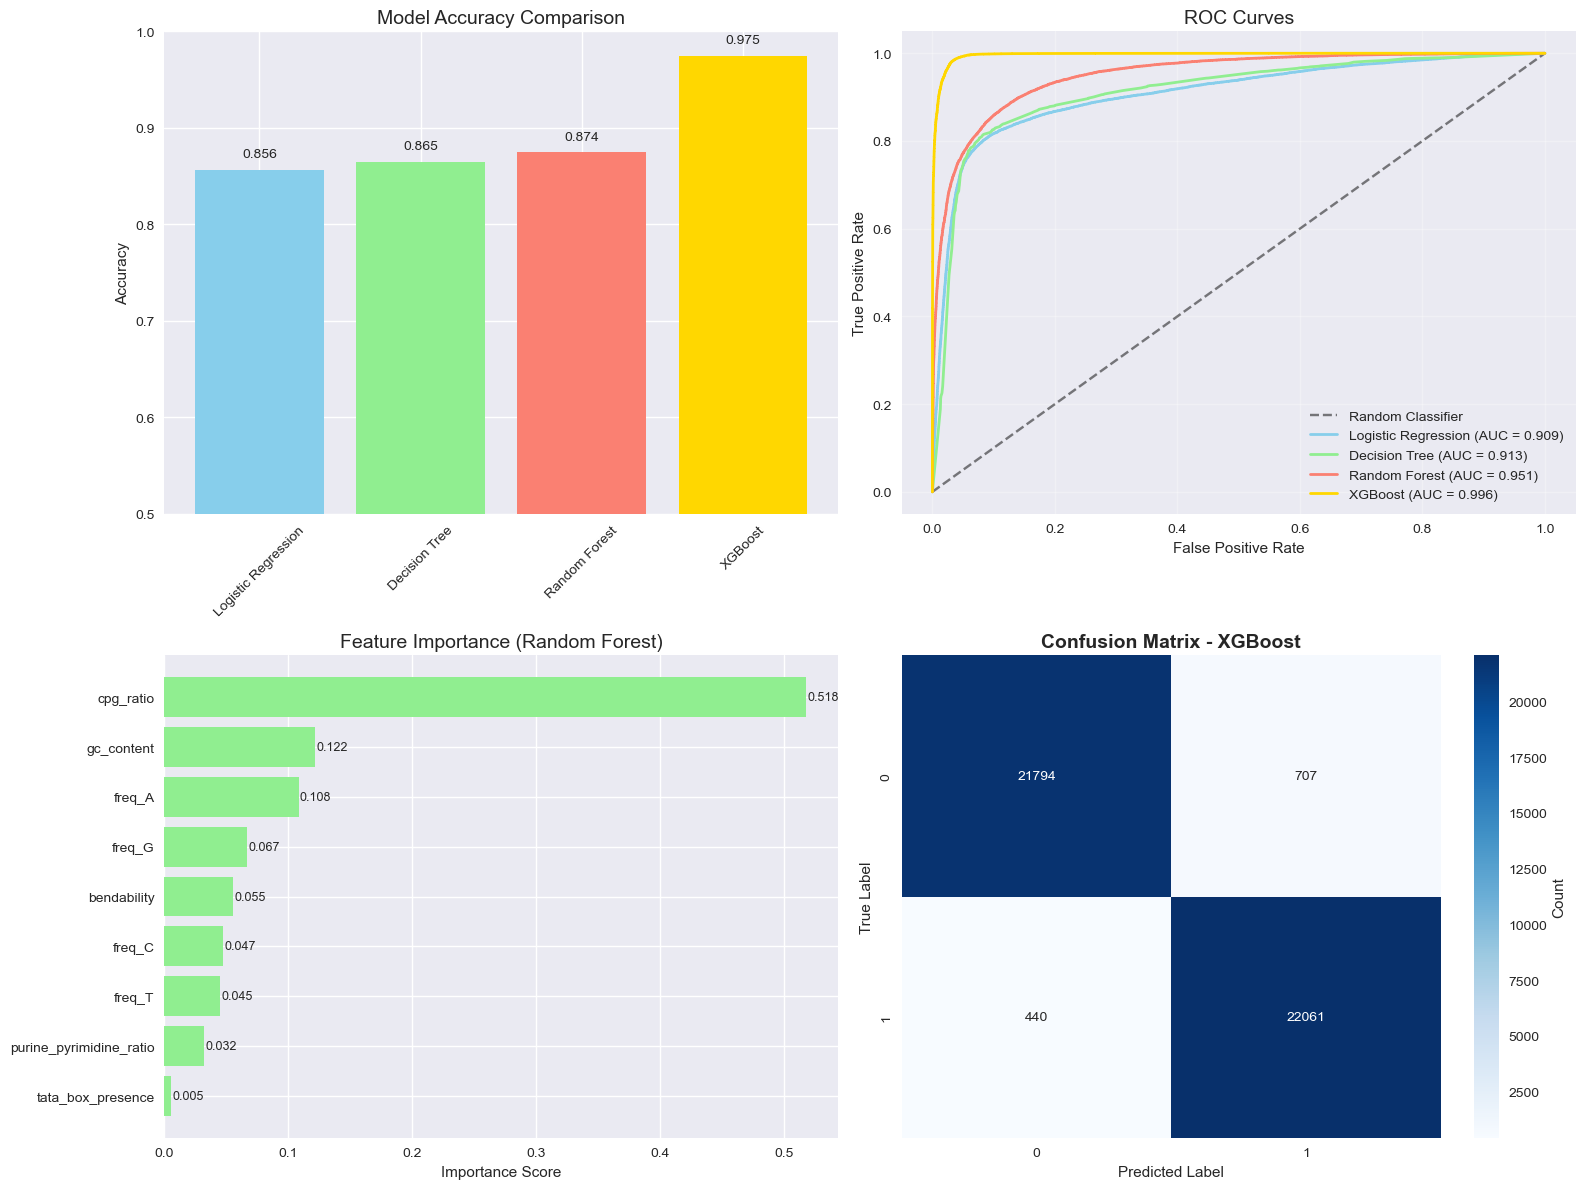

In [21]:
# Detailed visualization of results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
model_names = list(results.keys())
accuracies = [results[name]["accuracy"] for name in model_names]
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

bars = axes[0,0].bar(model_names, accuracies, color=colors)
axes[0,0].set_title('Model Accuracy Comparison', fontsize=14)
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim(0.5, 1.0)
axes[0,0].tick_params(axis='x', rotation=45)

# Add values on bars
for bar, acc in zip(bars, accuracies):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{acc:.3f}', ha='center', va='bottom')

# 2. ROC curves
axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

for name, color in zip(model_names, colors):
    if results[name]["y_pred_proba"] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[name]["y_pred_proba"])
        auc_score = results[name]["auc"]
        axes[0,1].plot(fpr, tpr, color=color, linewidth=2,
                      label=f'{name} (AUC = {auc_score:.3f})')

axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curves', fontsize=14)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Feature importance (Random Forest)
rf_model = results["Random Forest"]["model"]
if hasattr(rf_model, 'feature_importances_'):
    importance_idx = np.argsort(rf_model.feature_importances_)[-10:]  # Top 10
    importances = rf_model.feature_importances_[importance_idx]
    feature_names = [feature_cols[i] for i in importance_idx]
    
    bars = axes[1,0].barh(range(len(importance_idx)), importances, color='lightgreen')
    axes[1,0].set_yticks(range(len(importance_idx)))
    axes[1,0].set_yticklabels(feature_names)
    axes[1,0].set_title('Feature Importance (Random Forest)',  fontsize=14)
    axes[1,0].set_xlabel('Importance Score')
    
    # Add values
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[1,0].text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                       f'{width:.3f}', ha='left', va='center', fontsize=9)

# 4. Confusion matrix for best model
best_y_pred = results[best_model_name]["y_pred"]
cm = confusion_matrix(y_test, best_y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1], 
            cbar_kws={'label': 'Count'})
axes[1,1].set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=14)
axes[1,1].set_xlabel('Predicted Label')
axes[1,1].set_ylabel('True Label')

plt.tight_layout()
plt.show()